# Notebook 1 of the eLetter response to Hubbard & Bradley

In this notebook, we present synthetic tests showing that the common mode removal procedure proposed by Hubbard and Bradley may remove potential tectonic signal.

## Preambule

Before designing sophisticated synthetic tests, we can get a sense of whether or not common-mode removal may remove tectonic signal by looking at a very clear and unambiguous tectonic signal: the co-seismic phase of the Tohoku-Oki earthquake. 

In the first part of this notebook, we apply the stacking procedure of Bletery and Nocquet (2023) to the Tohoku-Oki co-seismic phase. We shift the time windows 12 h later than in the paper so that the co-seismic offset is apparent. We then apply the common-mode removal procedure proposed by Hubbard & Bradley and quatify how much tectonic signal it removes.

In [1]:
# Library cell

import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
import scipy.optimize
import pyeq.green.make
from pyacs.lib.coordinates import geo_spherical_distance
from datetime import datetime
from glob import glob

In [2]:
# Variables declaration cell

nsample = 576                        # Number of samples in the time windows (2 days of data sampled at 5 min) 
nd = int(nsample/2)                  # Number of samples considered to define displacement 0 
mu=29353000000                       # Shear modulus
L, W = 1, 1                          # Length and Width of the source (in km)
M = mu * L*1000 * W*1000             # Constant used to convert the stack into seismic moment

data_byEQ_dir_co = 'data_byEQ_coseismic'  # Folder containing previously downloaded time series from NGL
eq = '20110311T05:46:24_MW_9.0'           # Tohoku-Oki code name

eq_lat, eq_lon = 38.300, 142.370     # Latitude and Longitude of the Tohoku-Oki earthquake
cm_dist = 200                        # Distance considered to calculate the common mode (km)

t = np.arange(-48-1/24,0-1/24,1/12)  # Time vector definition

In [3]:
# Calculation of the Tohoku-Oki co-seismic stack (with, without the common-mode and common-mode alone)

np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir_co+'/'+eq+'/station_list.txt',dtype=str,usecols=0))
st_lon = np.atleast_1d(np.genfromtxt(data_byEQ_dir_co+'/'+eq+'/station_list.txt',dtype=float,usecols=1))
st_lat = np.atleast_1d(np.genfromtxt(data_byEQ_dir_co+'/'+eq+'/station_list.txt',dtype=float,usecols=2))
syn_east = np.atleast_1d(np.genfromtxt(data_byEQ_dir_co+'/'+eq+'/synthetics.txt',dtype=float,usecols=0))
syn_north = np.atleast_1d(np.genfromtxt(data_byEQ_dir_co+'/'+eq+'/synthetics.txt',dtype=float,usecols=1))
sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir_co+'/'+eq+'/sigmaj2.txt'))
sigmag2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir_co+'/'+eq+'/sigmag2.txt'))
sg2 = sum(np.divide(sigmag2,sigmaj2))
cm200e0, cm200n0, i = [], [], 0
stdist = np.zeros([len(np_code),1])
for code in np_code:
    ts = np.genfromtxt(data_byEQ_dir_co+'/'+eq+'/TS_'+code+'.dat')
    stdist[i] = geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon,eq_lat,0,unit='dec_deg')/1000
    obs_east = ts[:,7]-np.median(ts[0:nd,7])
    obs_north = ts[:,8]-np.median(ts[0:nd,8])
    if stdist[i] > cm_dist:
        cm200e0.append(obs_east)
        cm200n0.append(obs_north)
    i = i+1
cm200e = np.mean(np.array(cm200e0),0)
cm200n = np.mean(np.array(cm200n0),0)

dp = np.zeros([len(syn_east),nsample])
dp_cm200 = np.zeros([len(syn_east),nsample])
dpmcm200 = np.zeros([len(syn_east),nsample])
i=0
for code in np_code:
    ts = np.genfromtxt(data_byEQ_dir_co+'/'+eq+'/TS_'+code+'.dat')
    obs_east = ts[:,7]-np.median(ts[0:nd,7])
    obs_north = ts[:,8]-np.median(ts[0:nd,8])
    dp[i,:] = obs_east * syn_east[i]/sigmaj2[i] + obs_north * syn_north[i]/sigmaj2[i]
    dp_cm200[i,:] = cm200e * syn_east[i]/sigmaj2[i] + cm200n * syn_north[i]/sigmaj2[i] 
    dpmcm200[i,:] = (obs_east-cm200e) * syn_east[i]/sigmaj2[i] + (obs_north-cm200n) * syn_north[i]/sigmaj2[i]
    i = i+1  
stack, stack_cm, stackmcm = sum(dp)*M/sg2, sum(dp_cm200)*M/sg2, sum(dpmcm200)*M/sg2

Text(0.5, 1.0, 'Map of stations included (blue) and not included (red) in the commmon mode calculation')

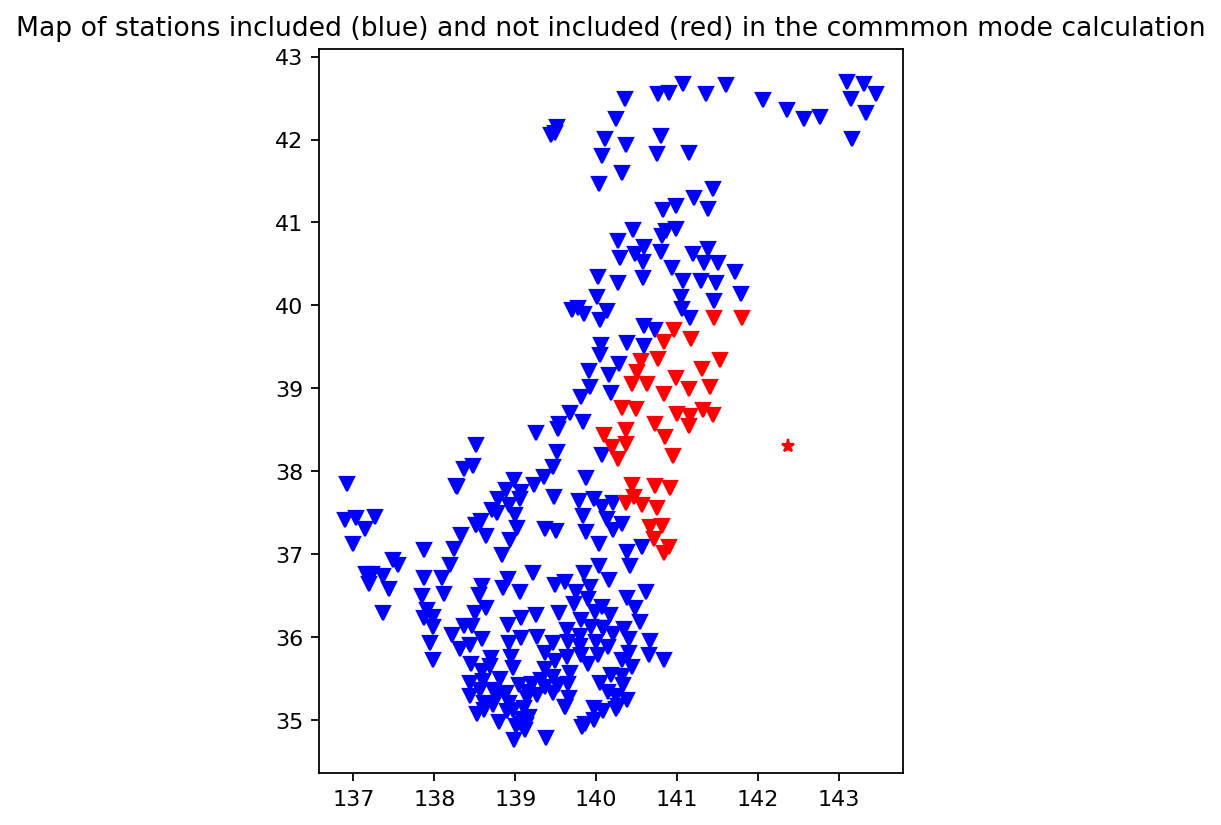

In [4]:
# Plot the station locations (blue > 200 km, red < 200 km from the epicenter)
# The blue stations are used to evaluate the common mode 

h = np.cos(eq_lat*np.pi/180)
plt.figure(figsize=(6*h, 6), dpi=160)
for i in range(len(st_lon)):
    if stdist[i] > cm_dist:
        plt.plot(st_lon[i],st_lat[i],'vb')
    else:
        plt.plot(st_lon[i],st_lat[i],'vr')
plt.plot(eq_lon,eq_lat,'*r')
plt.title('Map of stations included (blue) and not included (red) in the commmon mode calculation')

The common mode offset is 21% of the coseismic signal
The magnitude corresponding to the co-seismic offset in the stack is 8.8
The magnitude corresponding to the offset in the common mode stack is 8.3


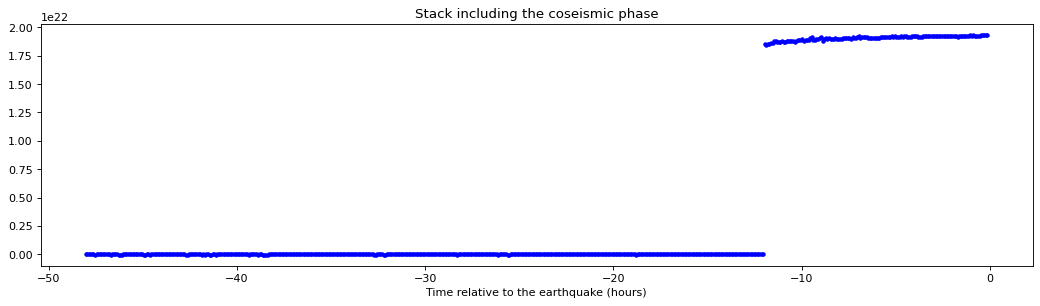

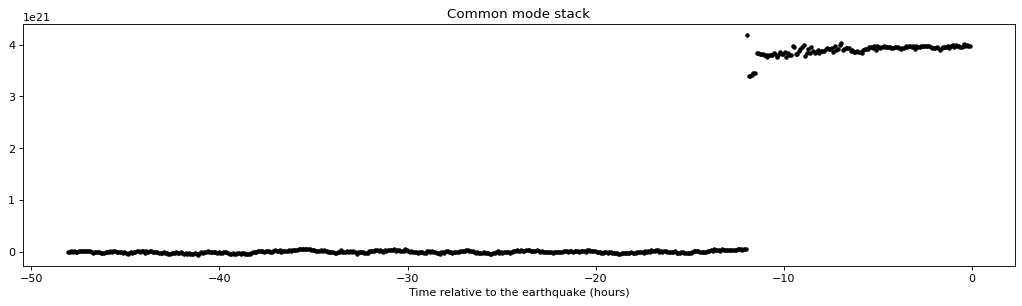

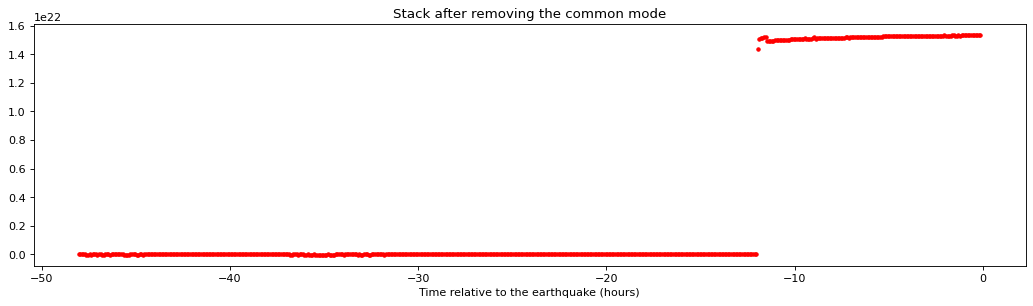

In [5]:
# Plot the results
# 1st plot: Tohoku co-seismic stack before removing the common mode
# 2nd plot: Stack of the common mode alone
# 3rd plot: Tohoku co-seismic stack after removing the common mode

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack,'b.')
plt.xlabel('Time relative to the earthquake (hours)')
plt.title('Stack including the coseismic phase')
#plt.savefig('tohoku_stack_coseismic.pdf')

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack_cm,'k.')
plt.xlabel('Time relative to the earthquake (hours)')
plt.title('Common mode stack')
#plt.savefig('tohoku_common-mode_stack_coseismic.pdf')

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stackmcm,'r.')
plt.xlabel('Time relative to the earthquake (hours)')
plt.title('Stack after removing the common mode')
#plt.savefig('tohoku_corrected_stack_coseismic.pdf')

M0 = np.median(stack[-120:-1])-np.median(stack[0:120])
M0_cm = np.median(stack_cm[-120:-1])-np.median(stack_cm[0:120])
cmr = M0_cm / M0
print('The common mode offset is '+str(round(cmr*100))+'% of the coseismic signal')
Mw = round((2/3)*np.log10(M0)-6.07,1)
Mw_cm = round((2/3)*np.log10(M0_cm)-6.07,1)
print('The magnitude corresponding to the co-seismic offset in the stack is '+str(Mw))
print('The magnitude corresponding to the offset in the common mode stack is '+str(Mw_cm))

### Conclusions of the preambule

If the common-mode removal only removes noise and not signal, then we should not see any tectonic signal in the stack of the common mode alone (average of time series recorded on stations located farther than 200 km away from the epicenter applied to all the stations).
The second plot (black curve) clearly shows that the common mode (calculated with the approach proposed by Hubbard and Bradley) contains obvious tectonic signal (equivalent to a Mw 8.3 earthquake, 21% of the actual co-seismic offset).
In this preambule, the signal-to-noise ratio is very large (a magnitude 9 earthquake is a very large signal!). So, in this case we would still see the co-seismic offset after removing the common mode (3rd plot in red). But what would happen if the signal was at the threshold of the noise level?

## Synthetic test on the Tohoku-Oki pre-seismic signal

To answer the above question, we will now consider a synthetic case in which we will impose a pre-seismic signal before the Tohoku-Oki earthquake, calculate the associated GPS displacements, add noise, and calculate the stack before and after removing the common mode.

In [6]:
from pyacs.lib.faultslip.fault_to_corners import fault_to_corners

In [7]:
data_byEQ_dir = 'data_byEQ'  # Folder containing previously downloaded time series from NGL (only pre-seismic this time)
eq = '20110311T05:46:24_MW_9.0' # Tohoku code name 

In [8]:
# Variables declaration cell

lon, lat, dep = 142.37, 38.3, 15  # Tohoku hypocenter longitude, latitude and depth (SCARDEC)
strike, dip, rake =  197, 14, 84  # Tohoku focal mechanism (SCARDEC)
L, W =  200, 120                  # Length and Width of the synthetic pre-slip area
#L, W = 1, 1                      # You may want to check what happens considering point-source pre-slip (does not change much)
Mo = 2.9e19                       # Moment fitted in the paper for Tohoku (Fig. 3C)
tau = 1.5                         # Time constant fitted in Fig. 3C (in hours)
nsample_s = 289                   # Redifining the time as we are limited to 24h05 time windows now (48h minus 23h55m)
nd_s = int(nsample_s/2)           # Redefining nd accordingly (used to define displacement 0)

In [9]:
# Load data (different from the preambule as we will look only at the pre-event time series here)

np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))
st_lon = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=1))
st_lat = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=2))
syn_east = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=0))
syn_north = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=1))
sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt'))
sigmag2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmag2.txt'))
sg2 = sum(np.divide(sigmag2,sigmaj2))

noise_east, noise_north = np.zeros([len(np_code),nsample_s]), np.zeros([len(np_code),nsample_s])
stdist = np.zeros([len(np_code),1])
i = 0
for code in np_code:
    ts = np.genfromtxt(data_byEQ_dir+'/'+eq+'/TS_'+code+'.dat')
    stdist[i] = geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon,eq_lat,0,unit='dec_deg')/1000
    noise_east[i] = ts[0:nsample_s,7]  # Time series 23h55min before the last day (east component)
    noise_north[i] = ts[0:nsample_s,8] # Time series 23h55min before the last day (north component)
    i = i+1

In [10]:
t = np.arange(-24-2/24,0-1/24,1/12)        # Redifining the time as we are limited to 24h05 time windows now (48h minus 23h55m)
stf = Mo * np.exp(tau * t) / (mu*L*W*1e6)  # Defining the source time function of the imposed pre-slip 
                                           # (based on the fit of Figure 3C)

Text(0, 0.5, 'Latitude')

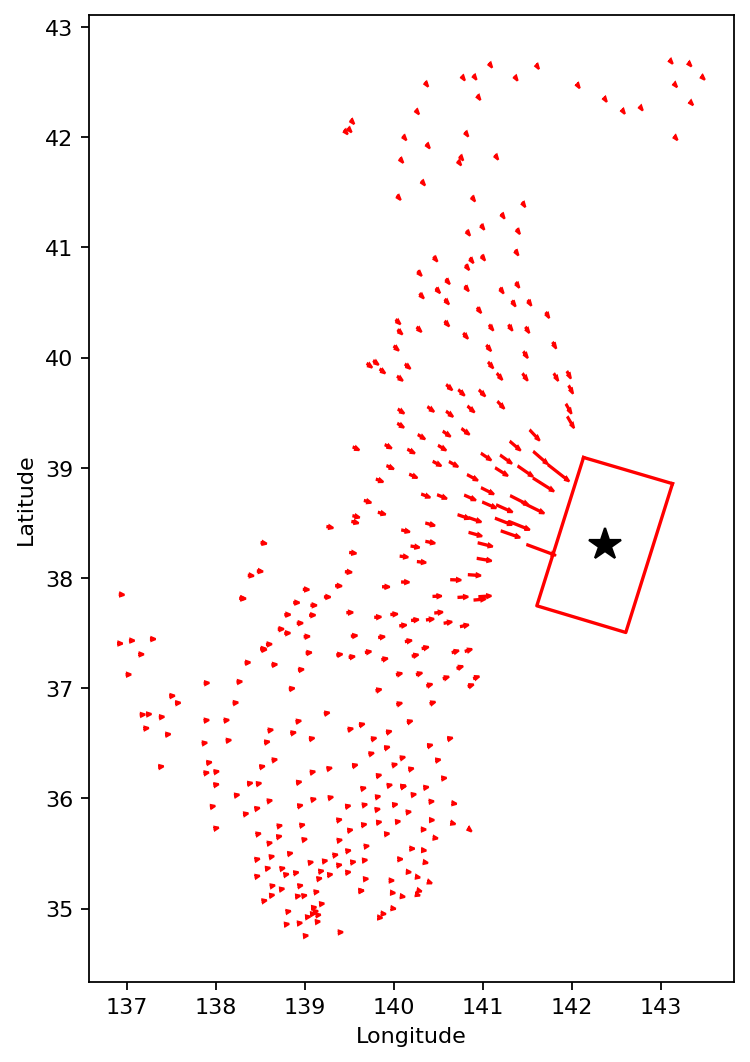

In [11]:
# Calcuate static synthetic displacement for a finite-fault source centered on the Tohoku hypocenter 

array_gps = np.transpose(np.array([st_lon,st_lat]))

AC = fault_to_corners(lon, lat,-dep, L/2, W/2, strike, dip)
lonC, latC, depC = lon+(lon-AC[2,0]), lat+(lat-AC[2,1]), dep+(dep+AC[2,2])

r_strike, r_rake = np.radians(strike), np.radians(rake)
geometry = np.array([[lonC,latC,depC,L,W,L*W,1,strike,dip,0,0,0,0,0,0,0,0,0,0,0,0,0]])
green = pyeq.green.make.nikkhoo_rde(geometry,array_gps,coor_type='geo',tensile=False,disp=True,strain=False,stress=False,lam=28758000000.0,mu=29353000000.0,verbose=False)
green_east = np.cos(r_rake)*green[0,:,0,0] + np.sin(r_rake)*green[0,:,0,1]
green_north = np.cos(r_rake)*green[0,:,1,0] + np.sin(r_rake)*green[0,:,1,1]

Es, Ns = [], []
for i in range(len(syn_east)):
    Es.append(green_east[i]*stf)
    Ns.append(green_north[i]*stf)

BC = fault_to_corners(lonC, latC, -depC, L, W, strike, dip)

h =(max(st_lon)-min(st_lon))*np.cos(38*np.pi/180)/(max(st_lat)-min(st_lat))
plt.figure(figsize=(8*h, 8), dpi=160)
plt.plot(lon,lat,'*k',markersize=15)
plt.plot(BC[:,0],BC[:,1],'r')
plt.plot([BC[3,0],BC[0,0]],[BC[3,1],BC[0,1]],'r')
for i in range(len(st_lon)):
    plt.arrow(st_lon[i],st_lat[i],green_east[i],green_north[i],width = 0.01,color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('synthetic_displacement_map.pdf')

In [12]:
# Generates the synthetic (de-meaned) time series 

green_e, green_n = [0]*noise_east, [0]*noise_north

for i in range(len(green_e)):
    green_e[i] = green_east[i] * stf  
    green_n[i] = green_north[i] * stf 

synthetic_east = noise_east + green_e
synthetic_north = noise_north + green_n

synthetic_east_0 = np.median(synthetic_east[:,0:nd_s],axis=1)    # Define 0 displacement as the median 
synthetic_north_0 = np.median(synthetic_north[:,0:nd_s],axis=1)  # of the first half of the time series

synthetic_east = (synthetic_east.T - synthetic_east_0.T).T
synthetic_north = (synthetic_north.T - synthetic_north_0.T).T

In [13]:
# Calculate the common mode

I = np.where(stdist>cm_dist)[0]
cm_east = np.mean(synthetic_east[I,:],axis=0)
cm_north = np.mean(synthetic_north[I,:],axis=0)

In [14]:
# Calculate the stacks before/after removing the common mode and common mode alone

dp, dp_cm, dp_mcm = [0]*noise_east, [0]*noise_east, [0]*noise_east
for i in range(len(green_e)):
    east = synthetic_east[i,:] 
    north = synthetic_north[i,:] 
    dp[i] = (east*syn_east[i] + north*syn_north[i]) / sigmaj2[i]
    dp_cm[i] = (cm_east*syn_east[i] + cm_north*syn_north[i]) / sigmaj2[i]
    dp_mcm[i] = ((east-cm_east)*syn_east[i] + (north-cm_north)*syn_north[i]) / sigmaj2[i]
stack, stack_cm, stack_mcm = sum(dp), sum(dp_cm), sum(dp_mcm)

Text(0.5, 1.0, 'Stack before removing the common mode')

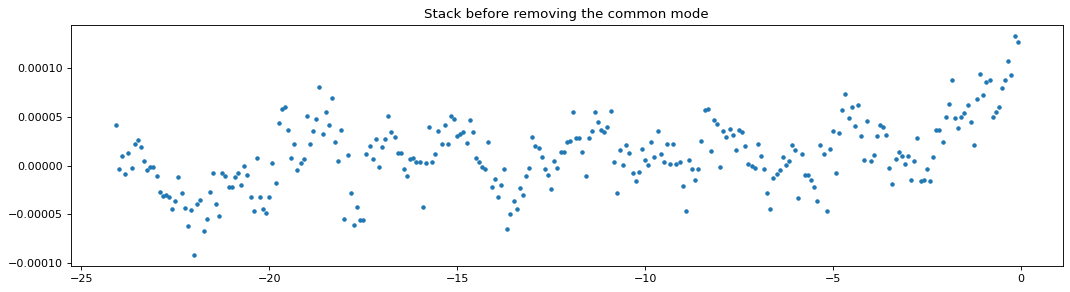

In [15]:
# Plot the stack before removing the common mode

plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack,'.')
plt.title('Stack before removing the common mode')

We see that applying the stacking procedure to the raw waveforms (blue plot above), the imposed pre-slip signal is apparent (this is normal as we imposed it!).

Text(0.5, 0, 'Time before earthquake (hours)')

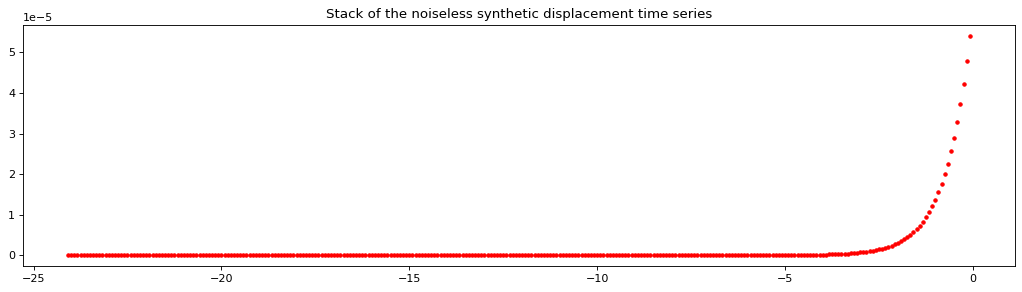

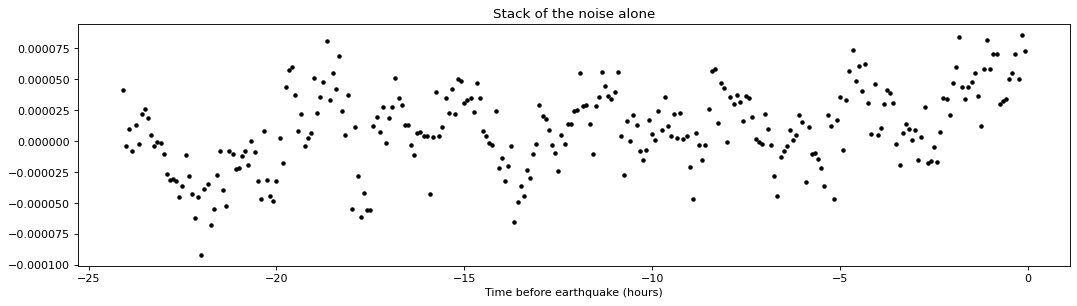

In [16]:
# Calculates and plots the stack of the noiseless synthetic displacements and the stack of the noise time series

dp_noiseless, dp_noise = [0]*noise_east, [0]*noise_east
for i in range(len(green_e)):
    dp_noiseless[i] = (green_e[i,:]*syn_east[i] + green_n[i,:]*syn_north[i]) / sigmaj2[i]
    noise_e_0, noise_n_0 = np.median(noise_east[i,0:int(nd/2)]), np.median(noise_north[i,0:int(nd/2)])
    dp_noise[i] = ((noise_east[i,:]-noise_e_0)*syn_east[i] + (noise_north[i,:]-noise_n_0)*syn_north[i]) / sigmaj2[i]
stack_noiseless, stack_noise = sum(dp_noiseless), sum(dp_noise)

plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack_noiseless,'.r')
plt.title('Stack of the noiseless synthetic displacement time series')
plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack_noise,'.k')
plt.title('Stack of the noise alone')
plt.xlabel('Time before earthquake (hours)')

The stack of the synthetic noisy displacements (in blue above) can be seen as the sum of the stack of the noiseless synthetic displacement time series and the stack of the noise time series. The purpose of the common mode removal is to separate the two contributions, so that the stack after removing the common mode approximate the red curve above and the stack of the common mode alone the black curve plot.
Let's see now (below) how efficient the common mode removal is at this task. 

Text(0.5, 0, 'Time before earthquake (hours)')

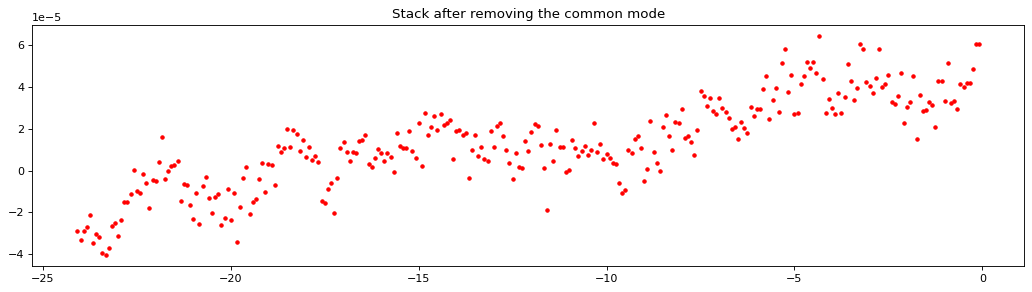

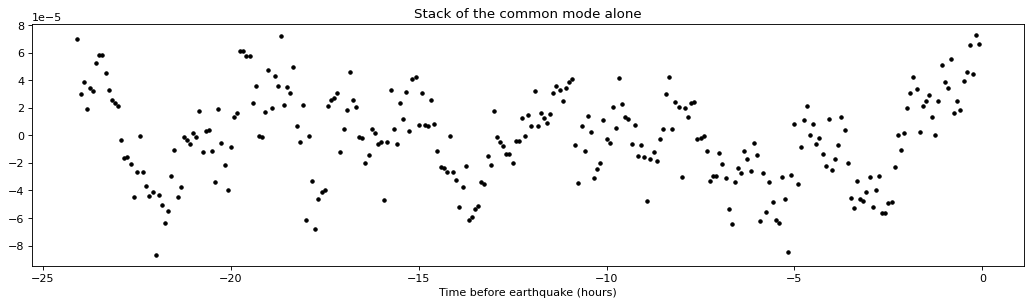

In [17]:
# Plot the stack after (red) removing the common mode, and the stack of the common-mode alone (black)

plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack_mcm,'.r')
plt.title('Stack after removing the common mode')
plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack_cm,'.k')
plt.title('Stack of the common mode alone')
plt.xlabel('Time before earthquake (hours)')

Applying the stack to the waveforms after removing a common mode (red plot above), we see that the imposed pre-slip exponential signal vanished. Interestingly the exponential shape signal appears in the stack of the common mode (black plot above), as it appears in the analysis of Hubbard and Bradley.

### Conclusions of the synthetic test on the Tohoku-Oki pre-seismic signal

We can see that the common mode removal fails to separate noise from signal, the largest part of the imposed pre-slip signal appearing in the estimate of the common mode noise instead of appearing in the denoised stack.

Let's now generalize the test to the global stack.

## Synthetic test on the global stack

Here we will generalize the test presented above for Tohoku to all the earthquakes in the global stack for which calculating a common mode is possible (given the available data).

In the default version of the scripts below, we consider an extended source (100 x 20 km) centered on the hypocenters of the 9 events counting for more than 4% in the global stack (events represented in Figure S5). You are welcome to uncomment the dedicated lines to check what happens for all earthquakes and considering point sources.

In [18]:
# Change variables

L, W = 100, 20           # We need to change W so that stike-slip events do not happen in the air
#L, W = 1, 1             # Uncommento check what happens considering point-source pre-slip    
Mo = 3.9e18              # Moment fitted in the paper for the global stack (Fig. 2C)
tau = 1.3                # Time constant fitted in Fig. 2C (in hours)

In [19]:
big9 = ['20110407T14:32:43_MW_7.1','20140310T05:18:13_MW_7.0','20121207T08:18:23_MW_7.2',\
        '20110311T05:46:24_MW_9.0','20131025T17:10:19_MW_7.1','20100404T22:40:43_MW_7.1',\
        '20120905T14:42:07_MW_7.5','20110309T02:45:20_MW_7.3','20161113T11:02:56_MW_7.9']
leq_file = [data_byEQ_dir+'/'+x+"/station_list.txt" for x in big9] # 9 main earthquakes in the global stack

#leq_file = glob(data_byEQ_dir+"/20*_MW_*/dot_product_stack.txt")  # Uncomment to apply to the full list 
                                                                   # of earthquakes
B = np.genfromtxt('scardec_M7_full.txt')  # Earthquake parameters

eq_lat, eq_lon, eq_date = B[:,7], B[:,8], []
for i in range(len(B)):
    eq_date.append(datetime(int(B[i,1]),int(B[i,2]),int(B[i,3]),int(B[i,4]),int(B[i,5])))

In [20]:
stf = Mo * np.exp(tau * t) / (mu*L*W*1e6)  # Redefinig the source time function

eq_stack, eq_stack_cm, eq_stack_mcm, eq_stack_noise, eq_stack_noise_free = [], [], [], [], []

for eq_file in leq_file:
    
    eq = eq_file.split('/')[-2]
    np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))
    Nst = len(np_code)
    
    if Nst > 1: # Hubbard & Bradley excluded events with a single station
        
        # Load data
        st_lon = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=1))
        st_lat = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=2))
        sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt'))
        syn_east = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=0))
        syn_north = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=1))
        I = int(np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0][0])
        lon, lat, dep, strike, dip, rake = B[I,8], B[I,7], B[I,9], B[I,10], B[I,11], B[I,12]
        if eq=='20100404T22:40:43_MW_7.1':                # the right focal plane is the 2nd one for this event 
            strike, dip, rake = B[I,13], B[I,14], B[I,15] # (unchecked outside of the 9 main events)
        
        # Compute synthetic displacement time series
        AC = fault_to_corners(lon, lat,-dep, L/2, W/2, strike, dip)
        lonC, latC, depC = lon+(lon-AC[2,0]), lat+(lat-AC[2,1]), dep+(dep+AC[2,2])
        array_gps = np.transpose(np.array([st_lon,st_lat]))
        r_strike, r_rake = np.radians(strike), np.radians(rake)
        geometry = np.array([[lonC,latC,depC,L,W,L*W,1,strike,dip,0,0,0,0,0,0,0,0,0,0,0,0,0]])
        green = pyeq.green.make.nikkhoo_rde(geometry,array_gps,coor_type='geo',tensile=False,disp=True,strain=False,stress=False,lam=28758000000.0,mu=29353000000.0,verbose=False)
        green_east = np.cos(r_rake)*green[0,:,0,0] + np.sin(r_rake)*green[0,:,0,1]
        green_north = np.cos(r_rake)*green[0,:,1,0] + np.sin(r_rake)*green[0,:,1,1]
        green_e, green_n = np.zeros([Nst,nsample_s]), np.zeros([Nst,nsample_s])
        for i in range(Nst):
            green_e[i] = green_east[i] * stf  
            green_n[i] = green_north[i] * stf
        
        # Get noise
        stdist = np.zeros([Nst,1])
        Te, Tn = np.zeros([Nst,nsample_s]), np.zeros([Nst,nsample_s])
        for i in range(Nst):
            ts = np.genfromtxt(data_byEQ_dir+'/'+eq+'/TS_'+np_code[i]+'.dat')
            Te[i,:], Tn[i,:] = ts[0:nsample_s,7]-np.median(ts[0:nd_s,7]), ts[0:nsample_s,8]-np.median(ts[0:nd_s,8])
            stdist[i] = geo_spherical_distance(st_lon[i],st_lat[i],0,lon,lat,0,unit='dec_deg')/1000
        
        # Compute the noisy synthetic time series
        synthetic_east = Te + green_e
        synthetic_north = Tn + green_n
        synthetic_east_0 = np.median(synthetic_east[:,0:nd_s],axis=1)    # Define 0 displacement as the median 
        synthetic_north_0 = np.median(synthetic_north[:,0:nd_s],axis=1)  # of the first half of the time series
        synthetic_east = (synthetic_east.T - synthetic_east_0.T).T
        synthetic_north = (synthetic_north.T - synthetic_north_0.T).T
            
        # Calculate the common mode (if more than 3 stations at > 200km, as in Hubbard & Bradley)   
        Icm = np.where(stdist>cm_dist)[0]
        if len(Icm)>3:
            cm_east = np.mean(synthetic_east[Icm,:],axis=0)
            cm_north = np.mean(synthetic_north[Icm,:],axis=0)
        else:
            cm_east = np.zeros([1,nsample_s])
            cm_north = np.zeros([1,nsample_s])
        cm_east = cm_east - np.median(cm_east[0:nd_s])
        cm_north = cm_north - np.median(cm_north[0:nd_s])
        
        # Calculate the stack
        dp, dp_cm, dm_mcm = np.zeros([Nst,nsample_s]), np.zeros([Nst,nsample_s]), np.zeros([Nst,nsample_s])
        dp_noise, dp_noise_free = np.zeros([Nst,nsample_s]), np.zeros([Nst,nsample_s])
        for i in range(Nst):
            east = synthetic_east[i,:] 
            north = synthetic_north[i,:]
            dp[i,:] = (east*syn_east[i] + north*syn_north[i]) / sigmaj2[i]
            dp_cm[i,:] = (cm_east*syn_east[i] + cm_north*syn_north[i]) / sigmaj2[i]
            dp_mcm[i,:] = ((east-cm_east)*syn_east[i] + (north-cm_north)*syn_north[i]) / sigmaj2[i]
            dp_noise[i,:] = (Te[i,:]*syn_east[i] + Tn[i,:]*syn_north[i]) / sigmaj2[i]
            dp_noise_free[i,:] = (green_e[i,:]*syn_east[i] + green_n[i,:]*syn_north[i]) / sigmaj2[i]
            
        eq_stack.append(sum(dp))
        eq_stack_cm.append(sum(dp_cm))
        eq_stack_mcm.append(sum(dp_mcm))
        eq_stack_noise.append(sum(dp_noise))
        eq_stack_noise_free.append(sum(dp_noise_free))
                    
eq_stack, eq_stack_cm, eq_stack_mcm = np.array(eq_stack), np.array(eq_stack_cm), np.array(eq_stack_mcm)
eq_stack_noise, eq_stack_noise_free = np.array(eq_stack_noise), np.array(eq_stack_noise_free)
stack, stack_cm, stack_mcm = sum(eq_stack), sum(eq_stack_cm), sum(eq_stack_mcm)
stack_noise, stack_noise_free = sum(eq_stack_noise), sum(eq_stack_noise_free)

Text(0.5, 0, 'Time before earthquake (hours)')

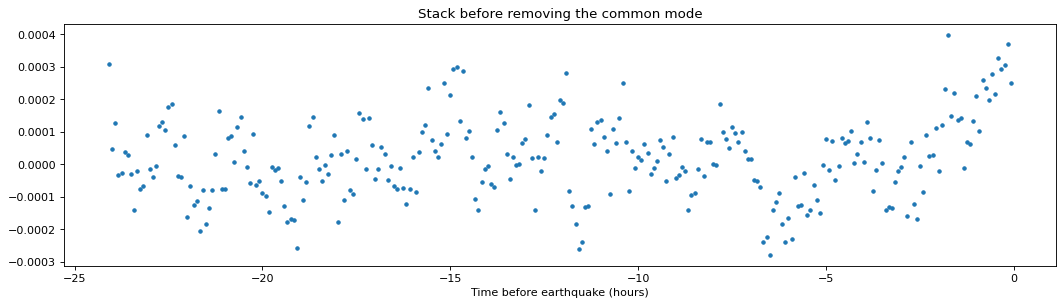

In [21]:
plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack,'.')
plt.title('Stack before removing the common mode')
plt.xlabel('Time before earthquake (hours)')

We see that, as for the Tohoku case, applying the stacking procedure to the raw waveforms (blue plot above), the imposed pre-slip signal is apparent in the global case as well. Again this is normal, we imposed it !

Text(0.5, 0, 'Time before earthquake (hours)')

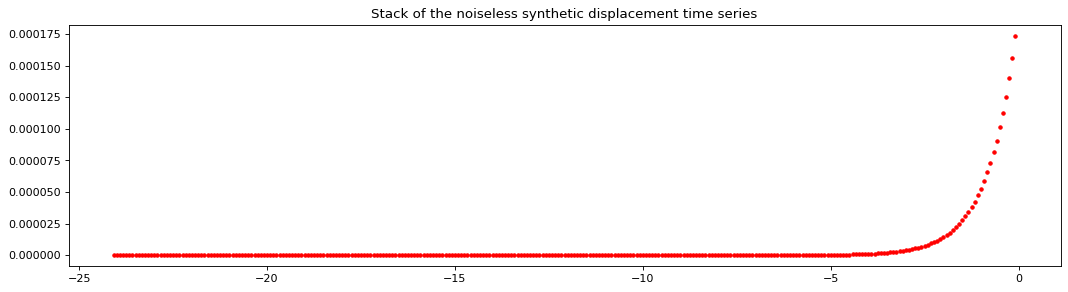

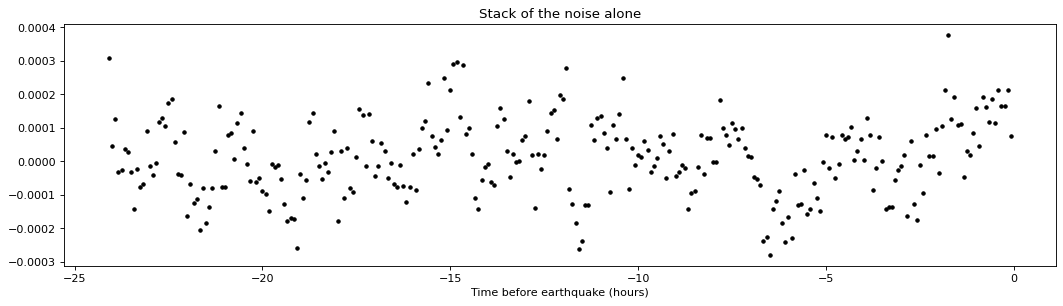

In [22]:
plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack_noise_free,'.r')
plt.title('Stack of the noiseless synthetic displacement time series')
plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack_noise,'.k')
plt.title('Stack of the noise alone')
plt.xlabel('Time before earthquake (hours)')

This time, the denoised (red) and noise (black) targets are the plots above. Let's see below how well the common-mode removal approximates those targets.

Text(0.5, 0, 'Time before earthquake (hours)')

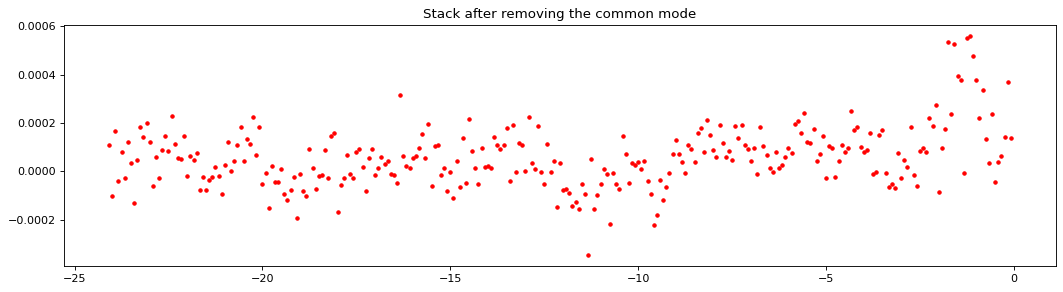

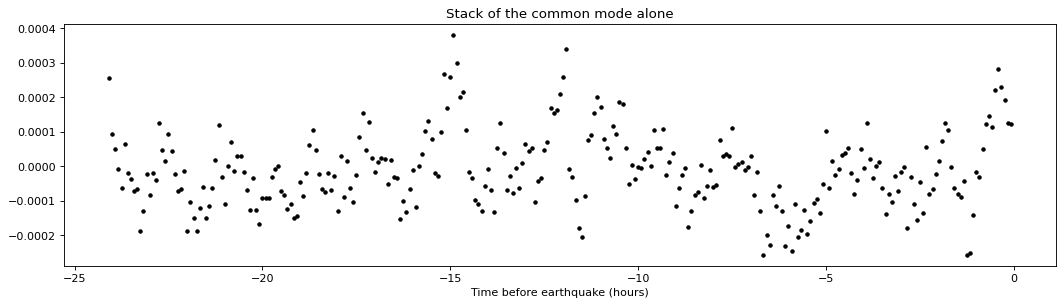

In [23]:
plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack_mcm,'.r')
plt.title('Stack after removing the common mode')
plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack_cm,'.k')
plt.title('Stack of the common mode alone')
plt.xlabel('Time before earthquake (hours)')

As for the Tohoku case, we see that the common-mode denoising procedure performs poorly at seperating the imposed synthetic signal from the empirical noise, with most of the imposed exponential signal appearing in the common-mode estimate (black plot) instead of appearing the denoised stack (red plot). It is intersting to note that the common-mode stack estimate looks very similar to the common-mode stack estimate found by Hubbard and Bradley on the real data. 

# Conclusion

The above tests demonstrate that removing a common mode in the GPS time series (the way Hubbard and Bradley did) may remove a potential tectonic precursury signal.
This is not a definite proof that the signal exists but this means that the analysis of Hubbard and Bradley is insufficient to prove that the signal does not exists.